In [5]:
# Cell 1: imports and helper functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# helper to print metrics
def print_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MSE: {mse:.4f}, R2: {r2:.4f}")

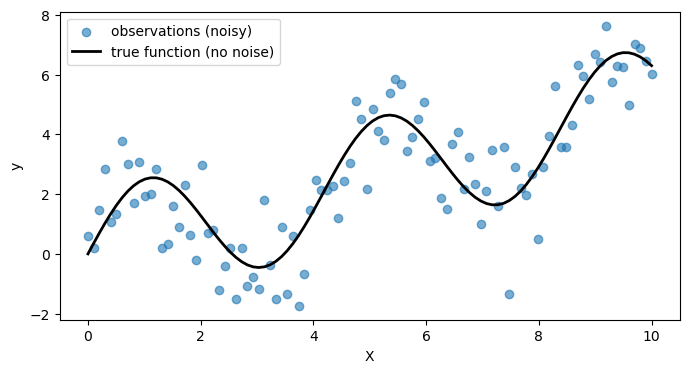

In [6]:
# Cell 2: create a noisy nonlinear dataset (sine + trend + noise)
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = 0.5 * X.ravel() + 2.0 * np.sin(1.5 * X.ravel())            # underlying function
noise = np.random.normal(scale=1.2, size=X.shape[0])
y = y_true + noise

# Plot the raw data and the underlying noiseless function
plt.figure(figsize=(8,4))
plt.scatter(X, y, alpha=0.6, label="observations (noisy)")
plt.plot(X, y_true, color="k", linewidth=2, label="true function (no noise)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

In [7]:
# Cell 3: train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Train size: 75 Test size: 25


Degree 1
 Train -> MSE: 3.4563, R2: 0.3852
 Test -> MSE: 2.0603, R2: 0.5235

Degree 3
 Train -> MSE: 3.0659, R2: 0.4546
 Test -> MSE: 1.5848, R2: 0.6335

Degree 9
 Train -> MSE: 1.0016, R2: 0.8218
 Test -> MSE: 1.4066, R2: 0.6747



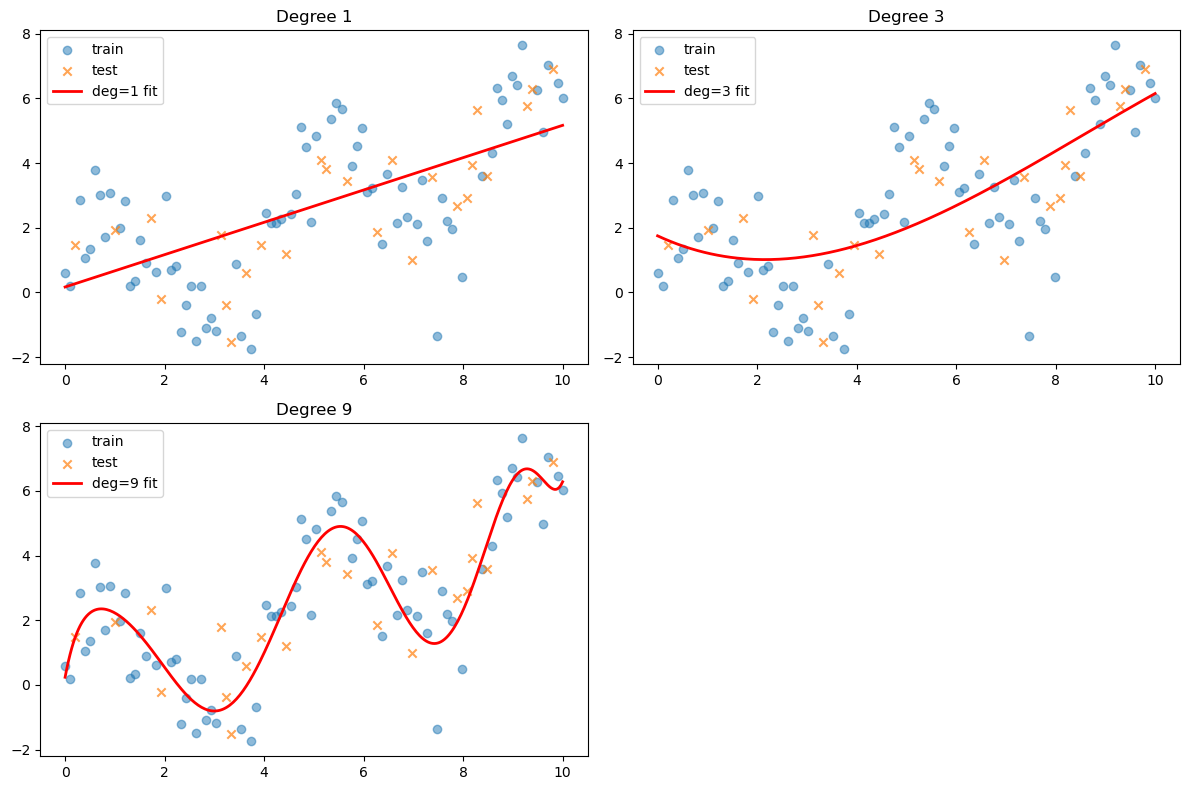

In [8]:
# Cell 4: fit polynomial models of degree 1, 3, and 9 and plot
degrees = [1, 3, 9]
plt.figure(figsize=(12,8))

for i, deg in enumerate(degrees, 1):
    # pipeline: polynomial features -> standardize -> linear regression
    model = make_pipeline(PolynomialFeatures(degree=deg, include_bias=False),
                          StandardScaler(),
                          LinearRegression())
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"Degree {deg}")
    print_metrics(" Train", y_train, y_train_pred)
    print_metrics(" Test", y_test, y_test_pred)
    print()

    # plot
    X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1,1)
    y_plot = model.predict(X_plot)

    plt.subplot(2, 2, i)
    plt.scatter(X_train, y_train, label="train", alpha=0.5)
    plt.scatter(X_test, y_test, label="test", alpha=0.7, marker='x')
    plt.plot(X_plot, y_plot, color='red', linewidth=2, label=f"deg={deg} fit")
    plt.title(f"Degree {deg}")
    plt.legend()

plt.tight_layout()
plt.show()

### Regularization: Ridge and Lasso on a high degree polynomial

Now take the degree 9 case and add Ridge and Lasso. We will compare coefficients, metrics and plots.

In [9]:
# Cell 5: ridge and lasso on degree 9
degree = 9

# baseline overfitted (no regularization)
pipe_lr = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                        StandardScaler(),
                        LinearRegression())
pipe_lr.fit(X_train, y_train)

# Ridge (L2)
pipe_ridge = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                           StandardScaler(),
                           Ridge(alpha=1.0))   # alpha is lambda, adjust to control strength

# Lasso (L1)
pipe_lasso = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                           StandardScaler(),
                           Lasso(alpha=0.01, max_iter=10000))  # lasso needs small alpha sometimes

pipe_ridge.fit(X_train, y_train)
pipe_lasso.fit(X_train, y_train)

# predictions
y_lr_train = pipe_lr.predict(X_train);   y_lr_test = pipe_lr.predict(X_test)
y_ridge_train = pipe_ridge.predict(X_train); y_ridge_test = pipe_ridge.predict(X_test)
y_lasso_train = pipe_lasso.predict(X_train); y_lasso_test = pipe_lasso.predict(X_test)

# print metrics
print("Plain degree 9 (no reg)")
print_metrics(" Train", y_train, y_lr_train)
print_metrics(" Test", y_test, y_lr_test)
print()
print("Ridge (alpha=1.0)")
print_metrics(" Train", y_train, y_ridge_train)
print_metrics(" Test", y_test, y_ridge_test)
print()
print("Lasso (alpha=0.01)")
print_metrics(" Train", y_train, y_lasso_train)
print_metrics(" Test", y_test, y_lasso_test)

Plain degree 9 (no reg)
 Train -> MSE: 1.0016, R2: 0.8218
 Test -> MSE: 1.4066, R2: 0.6747

Ridge (alpha=1.0)
 Train -> MSE: 3.0623, R2: 0.4553
 Test -> MSE: 1.5342, R2: 0.6452

Lasso (alpha=0.01)
 Train -> MSE: 3.0796, R2: 0.4522
 Test -> MSE: 1.5484, R2: 0.6419


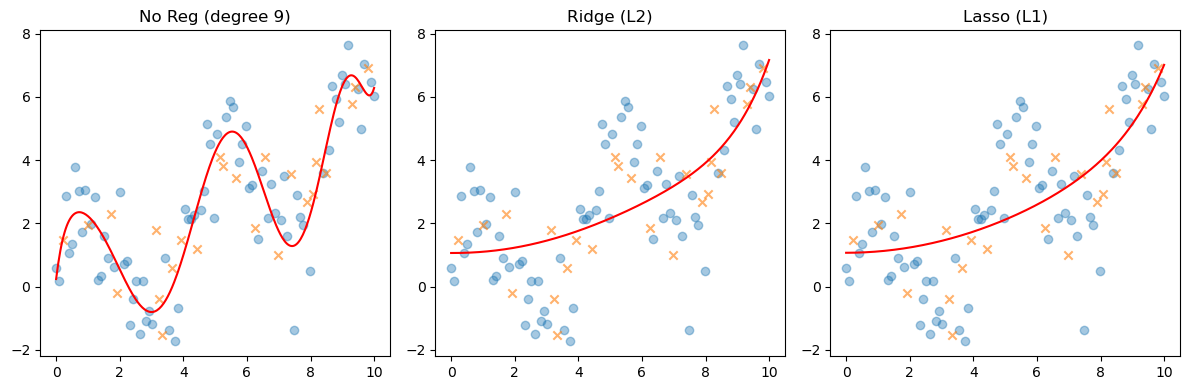

In [10]:
# Cell 6: plot the three fits side-by-side
X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1,1)
y_lr_plot = pipe_lr.predict(X_plot)
y_ridge_plot = pipe_ridge.predict(X_plot)
y_lasso_plot = pipe_lasso.predict(X_plot)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(X_train, y_train, alpha=0.4); plt.scatter(X_test, y_test, marker='x', alpha=0.6)
plt.plot(X_plot, y_lr_plot, color='red'); plt.title("No Reg (degree 9)")

plt.subplot(1,3,2)
plt.scatter(X_train, y_train, alpha=0.4); plt.scatter(X_test, y_test, marker='x', alpha=0.6)
plt.plot(X_plot, y_ridge_plot, color='red'); plt.title("Ridge (L2)")

plt.subplot(1,3,3)
plt.scatter(X_train, y_train, alpha=0.4); plt.scatter(X_test, y_test, marker='x', alpha=0.6)
plt.plot(X_plot, y_lasso_plot, color='red'); plt.title("Lasso (L1)")

plt.tight_layout()
plt.show()